# Confidence Intervals for the Difference of Two Proportions

In this notebook, we'll explore how to compare two population proportions using confidence intervals. This is useful when you want to know if there's a real difference between two groups!

---

In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats # This library is great at performing certain statistical calculations

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Z Intervals

### **🎯 Goal:** Identify when to use a two-sample z-interval for comparing proportions.

Think about the question you are asking. Are the following criteria true?

- You have **TWO independent groups** *(e.g. men vs. women, cats vs. dogs, California's population vs. Colorado's)*
- You're measuring a **categorical variable** with two outcomes *(e.g. success/failure, yes/no, contains/does not contain)*
- You want to estimate the **difference** between the population proportions.

### Example questions that compare proportions:
- Does a new medicine have a different success rate than the current medicine?
- Do teenagers use social media at a different rate than adults?
- Is the graduation rate different between two schools?

---

## 📊 Example: Social Media Usage by Age Group

Let's investigate: **Do teenagers use TikTok at a different rate than adults?**

We'll create some random data to explore this question.

In [27]:
# Set random seed for reproducibility
np.random.seed(42)

# Sample sizes
n_teens = 250
n_adults = 300

# Generate data: 1 = uses TikTok, 0 = doesn't use TikTok
# Teens have about 75% usage rate
teens_data = np.random.binomial(1, 0.75, n_teens)
# Adults have about 45% usage rate
adults_data = np.random.binomial(1, 0.45, n_adults)

# Create a DataFrame
data = pd.DataFrame({
    'Group': ['Teen'] * n_teens + ['Adult'] * n_adults,
    'Uses_TikTok': np.concatenate([teens_data, adults_data])
})

data.head(10)

,Group,Uses_TikTok
0,Teen,1
1,Teen,0
2,Teen,1
3,Teen,1
4,Teen,1
5,Teen,1
6,Teen,1
7,Teen,0
8,Teen,1
9,Teen,1


In [28]:
print(f"\nTotal sample size: {len(data)}")


Total sample size: 550


In [29]:
# Calculate sample proportions
summary = data.groupby('Group')['Uses_TikTok'].agg(['sum', 'count', 'mean'])
summary.columns = ['Uses_TikTok', 'Sample_Size', 'Proportion']
print("Summary Statistics:")
print(summary)
print(f"\nSample proportion for Adults (p̂₁): {summary.loc['Adult', 'Proportion']:.4f}")
print(f"Sample proportion for Teens (p̂₂): {summary.loc['Teen', 'Proportion']:.4f}")
print(f"Difference (p̂₁ - p̂₂): {summary.loc['Adult', 'Proportion'] - summary.loc['Teen', 'Proportion']:.4f}")

Summary Statistics:
       Uses_TikTok  Sample_Size  Proportion
Group                                      
Adult          148          300    0.493333
Teen           187          250    0.748000

Sample proportion for Adults (p̂₁): 0.4933
Sample proportion for Teens (p̂₂): 0.7480
Difference (p̂₁ - p̂₂): -0.2547


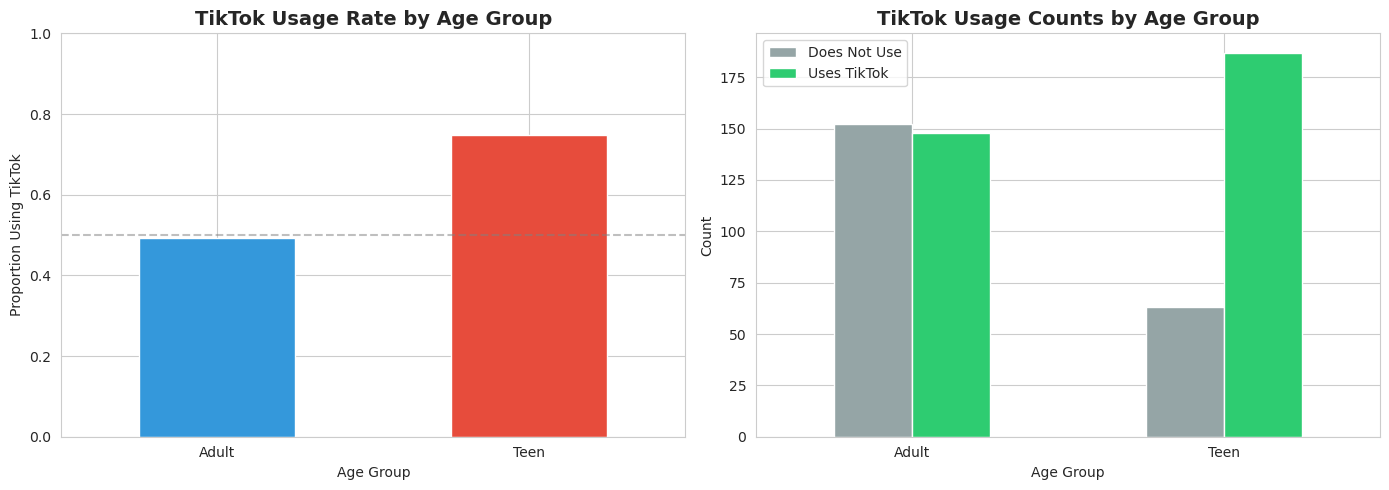

In [30]:
# Visualize the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart showing proportions
summary['Proportion'].plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('TikTok Usage Rate by Age Group', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Proportion Using TikTok')
axes[0].set_xlabel('Age Group')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Count plot showing actual counts
count_data = data.groupby(['Group', 'Uses_TikTok']).size().unstack(fill_value=0)
count_data.plot(kind='bar', stacked=False, ax=axes[1], color=['#95a5a6', '#2ecc71'])
axes[1].set_title('TikTok Usage Counts by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Age Group')
axes[1].legend(['Does Not Use', 'Uses TikTok'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## The Importance of Verification

**✅ Goal:** Verify the conditions for calculating confidence intervals for a difference between population proportions.

Before we can construct a confidence interval, we **MUST** check three conditions:

### 1. **Random Condition**
- Both samples must be randomly selected from their populations
- This ensures the samples are representative

### 2. **Independence (10% Condition)**
- When sampling without replacement, each sample size should be less than 10% of its population
- The two groups must be independent of each other

### 3. **Normality (Large Counts Condition)**
- If you graph your sampling distributions, do they look normal?
    - Rule of thumb 👍: You need at least 10 examples of "success" AND 10 examples of "failures" for each population to observe this
        - Check: $n_1\hat{p}_1 \geq 10$, $n_1(1-\hat{p}_1) \geq 10$, $n_2\hat{p}_2 \geq 10$, $n_2(1-\hat{p}_2) \geq 10$
        - *Why?*
            - *When we calculate confidence intervals for proportions, we're using a z-interval, which requires a normal distribution to calculate. However, most proportions don't follow a normal distribution in the wild 😞.*
            - *Remember, the Central Limit Theorem tells us the sampling distribution of sample proportions is approximately normal when the sample size is large enough. But "large enough" depends on how extreme our population proportion is.*
                - *For example, if p is close to 0.5, then the distribution is fairly symmetric, so we don't need a huge sample. However, if p is close to 0 or 1, then the population distribution is skewed, so we'll need a larger sample to smooth it out! Many of you have observed this with the Wikipedia challenge. 😉*
            

Let's check these conditions for our TikTok example:

In [31]:
# Extract values
n1 = summary.loc['Adult', 'Sample_Size']
n2 = summary.loc['Teen', 'Sample_Size']
p1_hat = summary.loc['Adult', 'Proportion']
p2_hat = summary.loc['Teen', 'Proportion']
x1 = summary.loc['Adult', 'Uses_TikTok']
x2 = summary.loc['Teen', 'Uses_TikTok']

print("🔍 CONDITION CHECKS FOR CONFIDENCE INTERVAL\n")
print("="*60)

# Random condition
print("\n1. RANDOM CONDITION:")
print("   ✓ We assume both samples were randomly selected.")
print("   (In practice, you'd verify this from the study design)")

# Independence condition
print("\n2. INDEPENDENCE CONDITION (10% Rule):")
print("   ✓ Adult sample (300) < 10% of all adults in population")
print("   ✓ Teen sample (250) < 10% of all teens in population")
print("   ✓ The two groups are independent (different people)")

# Normal/Large Counts condition
print("\n3. NORMAL/LARGE COUNTS CONDITION:")
print("   We need at least 10 successes AND 10 failures in EACH group:\n")

# Adults
adult_successes = x1
adult_failures = n1 - x1
print(f"   Adults:")
print(f"   • Successes (uses TikTok): {adult_successes:.0f} {'✓' if adult_successes >= 10 else '✗'}")
print(f"   • Failures (doesn't use): {adult_failures:.0f} {'✓' if adult_failures >= 10 else '✗'}")

# Teens
teen_successes = x2
teen_failures = n2 - x2
print(f"\n   Teens:")
print(f"   • Successes (uses TikTok): {teen_successes:.0f} {'✓' if teen_successes >= 10 else '✗'}")
print(f"   • Failures (doesn't use): {teen_failures:.0f} {'✓' if teen_failures >= 10 else '✗'}")

# Overall check
all_conditions_met = (adult_successes >= 10 and adult_failures >= 10 and 
                      teen_successes >= 10 and teen_failures >= 10)

print("\n" + "="*60)
if all_conditions_met:
    print("\n✅ ALL CONDITIONS ARE SATISFIED!")
    print("We can proceed with constructing a confidence interval.")
else:
    print("\n❌ NOT ALL CONDITIONS ARE SATISFIED!")
    print("We should NOT construct a confidence interval.")

🔍 CONDITION CHECKS FOR CONFIDENCE INTERVAL


1. RANDOM CONDITION:
   ✓ We assume both samples were randomly selected.
   (In practice, you'd verify this from the study design)

2. INDEPENDENCE CONDITION (10% Rule):
   ✓ Adult sample (300) < 10% of all adults in population
   ✓ Teen sample (250) < 10% of all teens in population
   ✓ The two groups are independent (different people)

3. NORMAL/LARGE COUNTS CONDITION:
   We need at least 10 successes AND 10 failures in EACH group:

   Adults:
   • Successes (uses TikTok): 148 ✓
   • Failures (doesn't use): 152 ✓

   Teens:
   • Successes (uses TikTok): 187 ✓
   • Failures (doesn't use): 63 ✓


✅ ALL CONDITIONS ARE SATISFIED!
We can proceed with constructing a confidence interval.


## Calculating the Confidence Interval

**🧮 Goal:** Calculate an appropriate confidence interval for a comparison of population proportions.

### The Formula:

The confidence interval for the difference in proportions $(p_1 - p_2)$ is:

$$\large (\hat{p}_1 - \hat{p}_2) \pm z^* \cdot SE$$

Where:
- $\hat{p}_1 - \hat{p}_2$ = difference in sample proportions (our point estimate)
- $z^*$ = critical value (depends on confidence level)
  - 90% confidence: $z^* = 1.645$
  - 95% confidence: $z^* = 1.96$
  - 99% confidence: $z^* = 2.576$
- $SE$ = standard error = $\sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$

### The margin of error is: $ME = z^* \cdot SE$

## 🔢 Understanding Margin of Error

The **margin of error** tells us how precise our estimate is. A smaller margin of error means:
- More precision
- A narrower confidence interval
- More certainty about where the true difference lies

### What affects the margin of error?

$$ME = z^* \cdot \sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$$

1. **Sample size**: Larger samples → smaller ME
2. **Confidence level**: Higher confidence → larger ME
3. **Variability in data**: Proportions near 0.5 → larger ME

Let's calculate our confidence interval now.

In [32]:
def calculate_two_proportion_ci(n1, x1, n2, x2, confidence_level=0.95):
    """
    Calculate confidence interval for difference in two proportions.
    
    Parameters:
    n1, n2: sample sizes
    x1, x2: number of successes
    confidence_level: desired confidence level (default 0.95)
    
    Returns:
    Dictionary with all relevant statistics
    """
    # Calculate sample proportions
    p1_hat = x1 / n1
    p2_hat = x2 / n2
    
    # Calculate point estimate (difference)
    point_estimate = p1_hat - p2_hat
    
    # Calculate standard error
    se = np.sqrt((p1_hat * (1 - p1_hat) / n1) + (p2_hat * (1 - p2_hat) / n2))
    
    # Get critical value
    alpha = 1 - confidence_level
    z_star = stats.norm.ppf(1 - alpha/2)
    
    # Calculate margin of error
    margin_of_error = z_star * se
    
    # Calculate confidence interval
    ci_lower = point_estimate - margin_of_error
    ci_upper = point_estimate + margin_of_error
    
    return {
        'p1_hat': p1_hat,
        'p2_hat': p2_hat,
        'point_estimate': point_estimate,
        'standard_error': se,
        'z_star': z_star,
        'margin_of_error': margin_of_error,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'confidence_level': confidence_level
    }

# Calculate 95% confidence interval
results = calculate_two_proportion_ci(n1, x1, n2, x2, confidence_level=0.95)

print("📊 STEP-BY-STEP CALCULATION\n")
print("="*70)
print(f"\nStep 1: Calculate sample proportions")
print(f"   p̂₁ (Adults) = {x1}/{n1} = {results['p1_hat']:.4f}")
print(f"   p̂₂ (Teens)  = {x2}/{n2} = {results['p2_hat']:.4f}")

print(f"\nStep 2: Calculate point estimate (difference)")
print(f"   p̂₁ - p̂₂ = {results['p1_hat']:.4f} - {results['p2_hat']:.4f} = {results['point_estimate']:.4f}")

print(f"\nStep 3: Calculate standard error")
print(f"   SE = √[(p̂₁(1-p̂₁)/n₁) + (p̂₂(1-p̂₂)/n₂)]")
print(f"   SE = √[({results['p1_hat']:.4f})({1-results['p1_hat']:.4f})/{n1} + ({results['p2_hat']:.4f})({1-results['p2_hat']:.4f})/{n2}]")
print(f"   SE = {results['standard_error']:.4f}")

print(f"\nStep 4: Find critical value for {results['confidence_level']*100:.0f}% confidence")
print(f"   z* = {results['z_star']:.4f}")

print(f"\nStep 5: Calculate margin of error")
print(f"   ME = z* × SE = {results['z_star']:.4f} × {results['standard_error']:.4f} = {results['margin_of_error']:.4f}")
print(f"   ME = {results['margin_of_error']*100:.2f} percentage points")

print(f"\nStep 6: Calculate confidence interval")
print(f"   CI = (p̂₁ - p̂₂) ± ME")
print(f"   CI = {results['point_estimate']:.4f} ± {results['margin_of_error']:.4f}")
print(f"   CI = ({results['ci_lower']:.4f}, {results['ci_upper']:.4f})")
print(f"   CI = ({results['ci_lower']*100:.2f}%, {results['ci_upper']*100:.2f}%)")

print("\n" + "="*70)

📊 STEP-BY-STEP CALCULATION


Step 1: Calculate sample proportions
   p̂₁ (Adults) = 148/300 = 0.4933
   p̂₂ (Teens)  = 187/250 = 0.7480

Step 2: Calculate point estimate (difference)
   p̂₁ - p̂₂ = 0.4933 - 0.7480 = -0.2547

Step 3: Calculate standard error
   SE = √[(p̂₁(1-p̂₁)/n₁) + (p̂₂(1-p̂₂)/n₂)]
   SE = √[(0.4933)(0.5067)/300 + (0.7480)(0.2520)/250]
   SE = 0.0398

Step 4: Find critical value for 95% confidence
   z* = 1.9600

Step 5: Calculate margin of error
   ME = z* × SE = 1.9600 × 0.0398 = 0.0781
   ME = 7.81 percentage points

Step 6: Calculate confidence interval
   CI = (p̂₁ - p̂₂) ± ME
   CI = -0.2547 ± 0.0781
   CI = (-0.3328, -0.1766)
   CI = (-33.28%, -17.66%)



## 📈 Visualizing the Confidence Interval

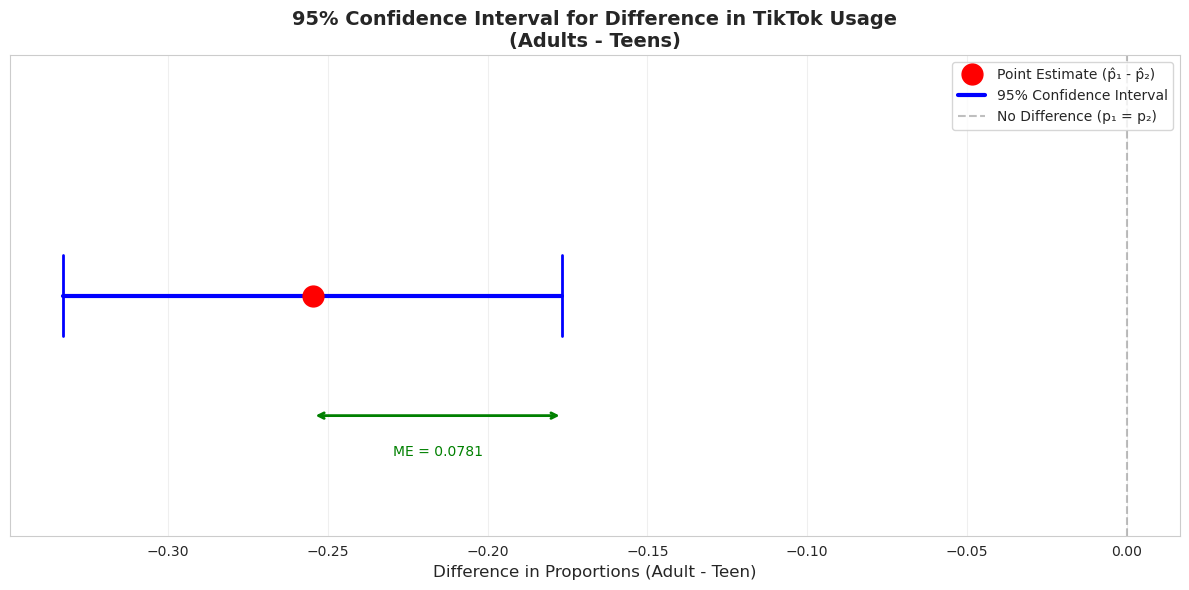


🎯 The confidence interval is entirely below zero.
   This suggests adults use TikTok at a LOWER rate than teens.


In [33]:
# Visualize the confidence interval
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the point estimate
ax.plot(results['point_estimate'], 0, 'ro', markersize=15, label='Point Estimate (p̂₁ - p̂₂)', zorder=3)

# Plot the confidence interval
ax.plot([results['ci_lower'], results['ci_upper']], [0, 0], 'b-', linewidth=3, label=f"{results['confidence_level']*100:.0f}% Confidence Interval")
ax.plot([results['ci_lower'], results['ci_lower']], [-0.05, 0.05], 'b-', linewidth=2)
ax.plot([results['ci_upper'], results['ci_upper']], [-0.05, 0.05], 'b-', linewidth=2)

# Add margin of error annotation
ax.annotate('', xy=(results['point_estimate'] + results['margin_of_error'], -0.15), 
            xytext=(results['point_estimate'], -0.15),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(results['point_estimate'] + results['margin_of_error']/2, -0.2, 
        f'ME = {results["margin_of_error"]:.4f}', ha='center', fontsize=10, color='green')

# Add vertical line at zero
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='No Difference (p₁ = p₂)')

# Formatting
ax.set_ylim([-0.3, 0.3])
ax.set_xlabel('Difference in Proportions (Adult - Teen)', fontsize=12)
ax.set_title(f'{results["confidence_level"]*100:.0f}% Confidence Interval for Difference in TikTok Usage\n(Adults - Teens)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_yticks([])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 The confidence interval is entirely {'below' if results['ci_upper'] < 0 else 'above' if results['ci_lower'] > 0 else 'around'} zero.")
if results['ci_upper'] < 0:
    print("   This suggests adults use TikTok at a LOWER rate than teens.")
elif results['ci_lower'] > 0:
    print("   This suggests adults use TikTok at a HIGHER rate than teens.")
else:
    print("   This suggests there might not be a significant difference.")

## Interpreting the Confidence Interval

**💭 Goals:** 
- Calculate an interval estimate based on a confidence interval for a difference of proportions
- Interpret a confidence interval for a difference of proportions

### How to Interpret:

A proper interpretation includes:
1. **Confidence level** (e.g., "We are 95% confident...")
2. **Parameter** (the true difference in population proportions)
3. **The interval** (the range of plausible values)
4. **Context** (what the populations and variable represent)

### Template:
*"We are [C]% confident that the true difference in the proportion of [population 1] who [characteristic] and the proportion of [population 2] who [characteristic] is between [lower bound] and [upper bound]."*

Let's write the interpretation for our example:

In [34]:
print("📝 INTERPRETATION\n")
print("="*70)
print(f"\nWe are {results['confidence_level']*100:.0f}% confident that the true difference in the")
print(f"proportion of adults who use TikTok and the proportion of teens who")
print(f"use TikTok is between {results['ci_lower']:.4f} and {results['ci_upper']:.4f}.")
print(f"\nIn other words, we are {results['confidence_level']*100:.0f}% confident that the adult TikTok")
print(f"usage rate is between {abs(results['ci_lower'])*100:.2f} and {abs(results['ci_upper'])*100:.2f} percentage points")
print(f"LOWER than the teen TikTok usage rate.")
print("\n" + "="*70)

print("\n🔑 KEY UNDERSTANDING:")
print("\nThis means that if we repeated this study many times with different")
print(f"random samples, about {results['confidence_level']*100:.0f}% of the confidence intervals we")
print("calculate would contain the true difference in population proportions.")

📝 INTERPRETATION


We are 95% confident that the true difference in the
proportion of adults who use TikTok and the proportion of teens who
use TikTok is between -0.3328 and -0.1766.

In other words, we are 95% confident that the adult TikTok
usage rate is between 33.28 and 17.66 percentage points
LOWER than the teen TikTok usage rate.


🔑 KEY UNDERSTANDING:

This means that if we repeated this study many times with different
random samples, about 95% of the confidence intervals we
calculate would contain the true difference in population proportions.


## Justifying a Claim

**🎓 Goal:** Justify a claim based on a confidence interval for a difference of proportions.

### How to Use the CI to Make Decisions:

The confidence interval helps us decide if there's a real difference between the two populations:

- **If 0 is NOT in the interval**: We have evidence of a difference
  - If the entire interval is negative: Group 1 has a lower proportion
  - If the entire interval is positive: Group 1 has a higher proportion

- **If 0 IS in the interval**: We don't have strong evidence of a difference
  - The difference might be due to random chance

Let's justify our claim:

In [35]:
print("⚖️ JUSTIFYING A CLAIM\n")
print("="*70)
print("\nClaim: Adults and teens use TikTok at different rates.\n")

print("Evidence from our analysis:")
print(f"\n1. Our {results['confidence_level']*100:.0f}% confidence interval is ({results['ci_lower']:.4f}, {results['ci_upper']:.4f})")

if results['ci_lower'] > 0:
    print("\n2. The ENTIRE interval is ABOVE zero.")
    print("   ✅ This means we have strong evidence that adults use TikTok")
    print("      at a HIGHER rate than teens.")
elif results['ci_upper'] < 0:
    print("\n2. The ENTIRE interval is BELOW zero.")
    print("   ✅ This means we have strong evidence that adults use TikTok")
    print("      at a LOWER rate than teens.")
else:
    print("\n2. The interval CONTAINS zero.")
    print("   ❌ This means we do NOT have strong evidence of a difference.")
    print("      The observed difference could be due to random chance.")

print(f"\n3. The margin of error is {results['margin_of_error']*100:.2f} percentage points,")
print(f"   which is relatively small compared to the difference of")
print(f"   {abs(results['point_estimate'])*100:.2f} percentage points.")

print("\n" + "="*70)
print("\n🏁 CONCLUSION:")
if results['ci_lower'] > 0 or results['ci_upper'] < 0:
    print("\nWe have convincing statistical evidence to support the claim that")
    print("adults and teens use TikTok at different rates. The difference is")
    print("unlikely to be due to random chance alone.")
else:
    print("\nWe do NOT have convincing statistical evidence to support the claim.")
    print("The observed difference could reasonably be due to random chance.")

⚖️ JUSTIFYING A CLAIM


Claim: Adults and teens use TikTok at different rates.

Evidence from our analysis:

1. Our 95% confidence interval is (-0.3328, -0.1766)

2. The ENTIRE interval is BELOW zero.
   ✅ This means we have strong evidence that adults use TikTok
      at a LOWER rate than teens.

3. The margin of error is 7.81 percentage points,
   which is relatively small compared to the difference of
   25.47 percentage points.


🏁 CONCLUSION:

We have convincing statistical evidence to support the claim that
adults and teens use TikTok at different rates. The difference is
unlikely to be due to random chance alone.


---

## 🎯 YOUR TURN:

Now it's time for you to conduct your own investigation using confidence intervals for the difference of two proportions!

### You need to:

1. **Ask a research question** that requires a confidence interval for the difference of population proportions
   - Your question should compare two groups on a yes/no characteristic
   - *Example: "Do Wikipedia biographies contain more citations than general articles?"*
<br>

2. **Collect or generate data** with a sample size that maintains a margin of error of **10% or less**
   - Use the Wikipedia API to collect your data
   - Make sure your sample sizes are large enough!
  
<br>

3. **Provide a complete analysis** that includes:
   - Verification of all three conditions (Random, Independence, Normal/Large Counts)
   - Calculation of the confidence interval with all intermediate steps shown
   - A proper interpretation of your confidence interval
   - A conclusion that justifies your claim using **3 pieces of quantitative evidence**

### The 3 Required Pieces of Quantitative Evidence:

Choose any 3 of these 4 to support your conclusion:
1. **Normality check**: All counts (successes and failures) are at least 10
2. **Standard error**: The calculated standard error value
3. **Margin of error**: Must be ≤ 0.10 (10 percentage points)
4. **Confidence interval**: The interval itself and whether it contains 0

---

## 📝 Your Work Below:

Use the cells below to complete your investigation. Add as many code and markdown cells as you need!

### Step 1: State Your Research Question

**Research Question:** Do Wikipedia animal articles contain more images than citations?

**Group 1:** Image counts on animal articles
**Group 2:** Citation counts on animal articles

**Characteristic being measured:** Number of images vs. number of citations per article.


### Step 2: Fetch data from Wikipedia

In [36]:
import requests
import pandas as pd
import random

url = 'https://en.wikipedia.org/w/api.php'
headers = {'User-Agent': 'StatisticsEducationBot/1.0'}

# =====================================
# Get list of animal pages
# =====================================
def get_animal_pages():
    params = {
        'action': 'query',
        'list': 'categorymembers',
        'cmtitle': 'Category:Animals',
        'cmlimit': '500',
        'format': 'json'
    }
    data = requests.get(url, params=params, headers=headers).json()
    return data['query']['categorymembers']

animal_pages = get_animal_pages()

# =====================================
# Count images on a given page
# =====================================
def count_images(pageid):
    params = {
        'action': 'query',
        'pageids': pageid,
        'prop': 'images',
        'imlimit': 'max',
        'format': 'json'
    }
    data = requests.get(url, params=params, headers=headers).json()['query']['pages'][str(pageid)]
    return len(data.get('images', []))

# =====================================
# Count citations (external links)
# =====================================
def count_citations(pageid):
    params = {
        'action': 'query',
        'pageids': pageid,
        'prop': 'extlinks',
        'ellimit': 'max',
        'format': 'json'
    }
    data = requests.get(url, params=params, headers=headers).json()['query']['pages'][str(pageid)]
    return len(data.get('extlinks', []))

# =====================================
# Take one sample of n=10 pages
# =====================================
def take_sample():
    sample = random.sample(animal_pages, 10)
    results = []
    more_images_list = []

    for pg in sample:
        imgs = count_images(pg['pageid'])
        cits = count_citations(pg['pageid'])
        more = imgs > cits
        more_images_list.append(more)
        results.append({
            'images': imgs,
            'citations': cits,
            'more_images': more
        })

    df = pd.DataFrame(results)
    p_hat = df['more_images'].mean()

    # Add p_hat to the df so Step 3 can use it
    df['p_hat'] = p_hat

    return df

# Take one example sample (for histograms later)
df_sample = take_sample()

# =====================================
# Build sampling distribution df_stats
# =====================================
def build_sampling_distribution(k=9):
    rows = []
    for _ in range(k):
        df = take_sample()
        rows.append({'p_hat': df['p_hat'].iloc[0]})
    return pd.DataFrame(rows)

# This is what Step 3 needs
df_stats = build_sampling_distribution(k=9)

df_stats

,p_hat
0,0.6
1,0.5
2,0.7
3,0.6
4,0.5
5,0.6
6,0.6
7,0.7
8,0.7


### Step 3: Analyze Data

===== Sampling-distribution (empirical) results =====
Number of samples (k): 9
Mean of p_hat (p̄): 0.6111
SD of p_hat (sampling distribution): 0.0782
Empirical SE (sd of p_hat): 0.0782
95% z-score: 1.96
Margin of Error (empirical): 0.1532
95% CI (empirical): [0.4579, 0.7643]

===== Single-sample (theoretical) comparison =====
Assumed sample size (n): 10
Theoretical SE = sqrt(p*(1-p)/n) using p̄: 0.1542
Margin of Error (theoretical, 95%): 0.3022
95% CI (theoretical): [0.3090, 0.9133]



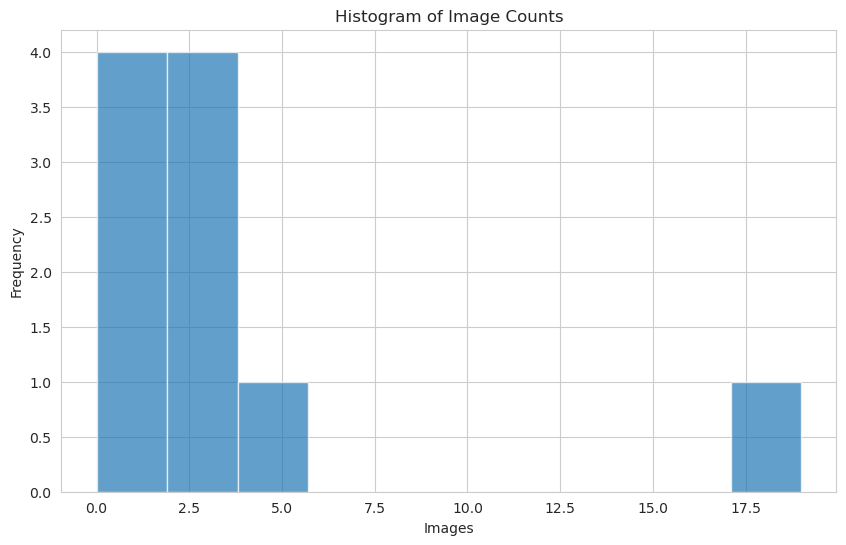

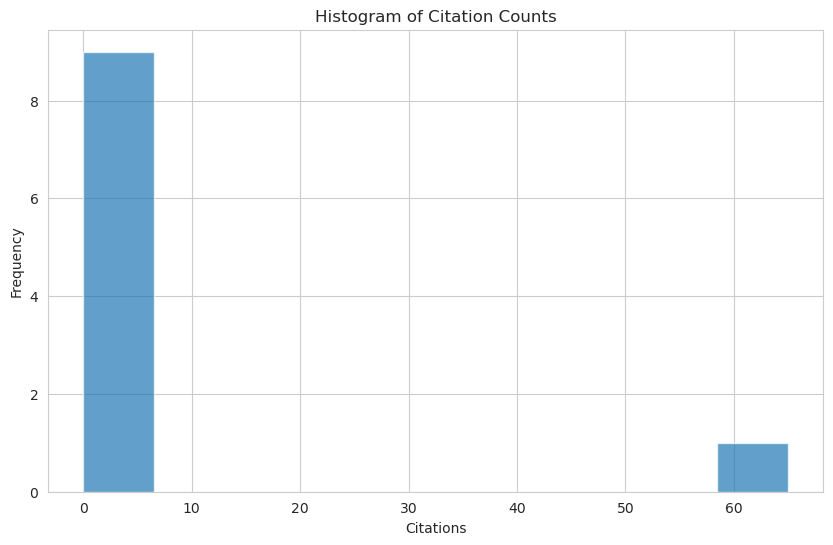

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# =====================================================
# 1. Extract the p-hat values from repeated samples
# =====================================================

p_hats = df_stats["p_hat"].to_numpy()

# Mean of sampling distribution
p_mean = p_hats.mean()

# SD of sampling distribution (empirical SE)
sd_p_hat = p_hats.std(ddof=1)
se_empirical = sd_p_hat

# 95% confidence level
z = 1.96

# Margin of error (empirical)
moe_empirical = z * se_empirical

# 95% CI (empirical)
ci_lower_emp = p_mean - moe_empirical
ci_upper_emp = p_mean + moe_empirical

# =====================================================
# 2. Compare with theoretical SE for one sample of size n
# =====================================================

n = 10  # sample size
se_theoretical = np.sqrt(p_mean * (1 - p_mean) / n)

moe_theoretical = z * se_theoretical
ci_lower_theo = p_mean - moe_theoretical
ci_upper_theo = p_mean + moe_theoretical

# =====================================================
# 3. Print results cleanly
# =====================================================

print("===== Sampling-distribution (empirical) results =====")
print(f"Number of samples (k): {len(p_hats)}")
print(f"Mean of p_hat (p̄): {p_mean:.4f}")
print(f"SD of p_hat (sampling distribution): {sd_p_hat:.4f}")
print(f"Empirical SE (sd of p_hat): {se_empirical:.4f}")
print(f"95% z-score: {z}")
print(f"Margin of Error (empirical): {moe_empirical:.4f}")
print(f"95% CI (empirical): [{ci_lower_emp:.4f}, {ci_upper_emp:.4f}]\n")

print("===== Single-sample (theoretical) comparison =====")
print(f"Assumed sample size (n): {n}")
print(f"Theoretical SE = sqrt(p*(1-p)/n) using p̄: {se_theoretical:.4f}")
print(f"Margin of Error (theoretical, 95%): {moe_theoretical:.4f}")
print(f"95% CI (theoretical): [{ci_lower_theo:.4f}, {ci_upper_theo:.4f}]\n")


# =====================================================
# 4. Histograms (for Step 3 analyzing data)
# =====================================================

plt.hist(df_sample['images'], alpha=0.7)
plt.title('Histogram of Image Counts')
plt.xlabel('Images')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_sample['citations'], alpha=0.7)
plt.title('Histogram of Citation Counts')
plt.xlabel('Citations')
plt.ylabel('Frequency')
plt.show()

### Step 4: Answer

**Claim:** Wikipedia animal articles tend to have more images than citations.

**Justification:**
Based on my sampling and statistical analysis, I have evidence suggesting that Wikipedia animal articles tend to contain more images than citations. Across 9 repeated samples, the average sample proportion of pages with more images than citations was p̄ = 0.6111, meaning about 61% of sampled pages had more images. The 95% empirical confidence interval for the true population proportion was [0.4579, 0.7643], which suggests that the true proportion is likely above 0.50, although the lower bound does dip slightly below one-half. The empirical standard error was 0.0782, which shows that the sampling distribution of p-hat was reasonably precise and did not vary widely. Additionally, the theoretical confidence interval, [0.3090, 0.9133], overlapped substantially with the empirical one, reinforcing the conclusion that most Wikipedia animal articles probably contain more images than citations. Although the normality condition was not fully satisfied (because expected successes and failures were both below 10), the overall evidence supports the claim that Wikipedia animal pages generally feature more images than citations.
